In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json

import scipy as sp
from scipy import signal

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)): 
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [4]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i]) 
        dataY.append(d_y[i + fore_cast,:])
    
    return np.array(dataX), np.array(dataY)

In [6]:
working_dir = os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\SKS\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code


In [7]:
#inclined_files = ['SKS_2_I.xlsx',  'SKS_3_I.xlsx',  'SKS_4_I.xlsx','SKS_5_I.xlsx', 'SD_2_I.xlsx',  'SD_3_I.xlsx',  'SD_4_I.xlsx','SD_5_I.xlsx']
file_name = ['SKS_2_I.xlsx', 'SKS_3_I.xlsx','SKS_0_I.xlsx', 'SKS_5_I.xlsx','SKS_4_I.xlsx']

file_list=[]

for i in range (len(file_name)):
    file_list.append(pd.read_excel(excel_path + file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)


In [8]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294657 entries, 0 to 294656
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_ank      294657 non-null  float64
 1   l_ph_fo       294657 non-null  float64
 2   l_ph_hip      294657 non-null  float64
 3   n_lcop        294657 non-null  float64
 4   n_lgrf        294657 non-null  float64
 5   n_rcop        294657 non-null  float64
 6   n_rgrf        294657 non-null  float64
 7   perc_new      294657 non-null  float64
 8   r_ph_ank      294657 non-null  float64
 9   r_ph_fo       294657 non-null  float64
 10  r_ph_hip      294657 non-null  float64
 11  strike_frame  294657 non-null  int64  
dtypes: float64(11), int64(1)
memory usage: 27.0 MB


In [9]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data)):
    if (all_data['perc_new'][i] == 100):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table
        

,l_ph_ank,l_ph_fo,l_ph_hip,n_lcop,n_lgrf,n_rcop,n_rgrf,perc_new,r_ph_ank,r_ph_fo,r_ph_hip,strike_frame
0,0.784569,0.704076,0.925156,0.072901,0.024335,0.928232,0.869968,0.000000,0.747553,0.775148,0.657878,1
1,0.780402,0.700581,0.921260,0.086464,0.038102,0.930349,0.860739,0.448430,0.746286,0.771666,0.645275,2
2,0.776891,0.696279,0.917522,0.101879,0.055124,0.931300,0.849147,0.896861,0.745075,0.768584,0.629093,3
3,0.773870,0.690952,0.913916,0.119179,0.075486,0.931008,0.835048,1.345291,0.743909,0.765830,0.608004,4
4,0.771223,0.684283,0.910416,0.138356,0.099007,0.929413,0.818313,1.793722,0.742778,0.763343,0.580463,5
...,...,...,...,...,...,...,...,...,...,...,...,...
293396,0.849499,0.738950,0.991208,0.041392,0.000000,0.932547,0.917721,97.474747,0.765466,0.773760,0.682299,194
293397,0.826018,0.737681,0.981863,0.047789,0.000000,0.936466,0.920527,97.979798,0.762974,0.769079,0.672711,195
293398,0.810889,0.736263,0.972774,0.055346,0.000000,0.939760,0.920682,98.484848,0.760692,0.765356,0.660591,196
293399,0.800400,0.734681,0.963995,0.064142,0.000000,0.942334,0.918158,98.989899,0.758591,0.762299,0.644863,197


In [10]:
source_table = source_table.drop(["n_lgrf","n_rgrf"], axis = 1)
source_table

,l_ph_ank,l_ph_fo,l_ph_hip,n_lcop,n_rcop,perc_new,r_ph_ank,r_ph_fo,r_ph_hip,strike_frame
0,0.784569,0.704076,0.925156,0.072901,0.928232,0.000000,0.747553,0.775148,0.657878,1
1,0.780402,0.700581,0.921260,0.086464,0.930349,0.448430,0.746286,0.771666,0.645275,2
2,0.776891,0.696279,0.917522,0.101879,0.931300,0.896861,0.745075,0.768584,0.629093,3
3,0.773870,0.690952,0.913916,0.119179,0.931008,1.345291,0.743909,0.765830,0.608004,4
4,0.771223,0.684283,0.910416,0.138356,0.929413,1.793722,0.742778,0.763343,0.580463,5
...,...,...,...,...,...,...,...,...,...,...
293396,0.849499,0.738950,0.991208,0.041392,0.932547,97.474747,0.765466,0.773760,0.682299,194
293397,0.826018,0.737681,0.981863,0.047789,0.936466,97.979798,0.762974,0.769079,0.672711,195
293398,0.810889,0.736263,0.972774,0.055346,0.939760,98.484848,0.760692,0.765356,0.660591,196
293399,0.800400,0.734681,0.963995,0.064142,0.942334,98.989899,0.758591,0.762299,0.644863,197


In [11]:
x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [12]:
data_y = y.values.reshape(-1,2)

In [13]:
type(data_y)

numpy.ndarray

In [15]:

#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25, 
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [16]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)


(220039, 10, 9)
(220039, 2)
(73340, 10, 9)
(73340, 2)


In [19]:
train_x.shape

(220039, 10, 9)

In [20]:
n1=validation_x.shape[0]
val_x=validation_x[1:int(n1/10),:]
val_y=validation_y[1:int(n1/10),:]
print(val_x.shape)
print(val_y.shape)

(7333, 10, 9)
(7333, 2)


In [22]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.005
	epochs_drop = 10
	lrate=initial_lrate - 0.00001 
	# lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


In [23]:
lr = 0.001
epochs = 20
batch = 128

serie_size = train_x.shape[1]
n_features = train_x.shape[2]
enc_dec_1 = Sequential()
enc_dec_1.add(InputLayer((10, train_x.shape[2])))
enc_dec_1.add(Conv1D(filters=32, kernel_size=3,strides=1,
    activation='relu', padding='same'))            
enc_dec_1.add(AveragePooling1D(pool_size=3))
# enc_dec_1.add(RepeatVector(10))

enc_dec_1.add(LSTM(32,  return_sequences=True))
enc_dec_1.add(LSTM(16,  activation='relu'))
enc_dec_1.add(L.RepeatVector((10)))
enc_dec_1.add(LSTM(16,  return_sequences=True))
enc_dec_1.add(LSTM(32,  activation='relu', return_sequences=True))
enc_dec_1.add(L.TimeDistributed(L.Dense(n_features)))


enc_dec_1.summary()
adam = optimizers.Adam(lr)
enc_dec_1.compile(loss='mse', optimizer=adam)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            896       
                                                                 
 average_pooling1d (AverageP  (None, 3, 32)            0         
 ooling1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 3, 32)             8320      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVector  (None, 10, 16)           0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 10, 16)            2

In [24]:
encoder_decoder_history = enc_dec_1.fit(train_x, train_x, 
                                              batch_size=batch, 
                                              epochs=epochs, 
                                              verbose=1)

Epoch 1/20
1720/1720 [==============================] - 20s 9ms/step - loss: 0.0175
Epoch 2/20
1720/1720 [==============================] - 15s 9ms/step - loss: 0.0048
Epoch 3/20
1720/1720 [==============================] - 15s 9ms/step - loss: 0.0039
Epoch 4/20
1720/1720 [==============================] - 16s 9ms/step - loss: 0.0033
Epoch 5/20
1720/1720 [==============================] - 16s 9ms/step - loss: 0.0028
Epoch 6/20
1720/1720 [==============================] - 15s 9ms/step - loss: 0.0025
Epoch 7/20
1720/1720 [==============================] - 15s 9ms/step - loss: 0.0022
Epoch 8/20
1720/1720 [==============================] - 15s 9ms/step - loss: 0.0020
Epoch 9/20
1720/1720 [==============================] - 15s 9ms/step - loss: 0.0019
Epoch 10/20
1720/1720 [==============================] - 15s 9ms/step - loss: 0.0017
Epoch 11/20
1720/1720 [==============================] - 15s 9ms/step - loss: 0.0016
Epoch 12/20
1720/1720 [==============================] - 15s 9ms/step - lo

In [25]:
encoder = Model(inputs=enc_dec_1.inputs, outputs=enc_dec_1.layers[4].output)
train_encoded = encoder.predict(train_x)
validation_encoded = encoder.predict(validation_x)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

2292/2292 [==============================] - 4s 2ms/step
Encoded time-series shape (220039, 10, 16)
Encoded time-series sample [[0.9567162  3.308762   3.984535   0.48509932 1.8581126  0.6546353
  2.799475   0.7309456  3.4313571  0.         0.27379382 5.0141277
  2.0521095  6.3088083  2.3577802  6.5664988 ]
 [0.9567162  3.308762   3.984535   0.48509932 1.8581126  0.6546353
  2.799475   0.7309456  3.4313571  0.         0.27379382 5.0141277
  2.0521095  6.3088083  2.3577802  6.5664988 ]
 [0.9567162  3.308762   3.984535   0.48509932 1.8581126  0.6546353
  2.799475   0.7309456  3.4313571  0.         0.27379382 5.0141277
  2.0521095  6.3088083  2.3577802  6.5664988 ]
 [0.9567162  3.308762   3.984535   0.48509932 1.8581126  0.6546353
  2.799475   0.7309456  3.4313571  0.         0.27379382 5.0141277
  2.0521095  6.3088083  2.3577802  6.5664988 ]
 [0.9567162  3.308762   3.984535   0.48509932 1.8581126  0.6546353
  2.799475   0.7309456  3.4313571  0.         0.27379382 5.0141277
  2.0521095  6.

In [26]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 9)]           0         
                                                                 
 conv1d (Conv1D)             (None, 10, 32)            896       
                                                                 
 average_pooling1d (AverageP  (None, 3, 32)            0         
 ooling1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 3, 32)             8320      
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector (RepeatVector  (None, 10, 16)           0         
 )                                                           

In [27]:
mlp_model = Sequential()
# mlp_model.add(InputLayer(()))

mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1]*train_encoded.shape[2])))
# mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))

mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(2))
mlp_model.summary()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
adam = optimizers.Adam(lr_schedule)

mlp_model.compile(loss='mse', optimizer=adam)
lrate = LearningRateScheduler(step_decay)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32)                5152      
                                                                 
 dense_2 (Dense)             (None, 8)                 264       
                                                                 
 dense_3 (Dense)             (None, 2)                 18        
                                                                 
Total params: 5,434
Trainable params: 5,434
Non-trainable params: 0
_________________________________________________________________


In [28]:
epochs = 50
# lrate = LearningRateScheduler(step_decay)
monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=3, verbose=1, mode='auto')
train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))

# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]))
callback_list = [monitor]
mlp_history = mlp_model.fit(train_encoded_reshaped , train_y, callbacks=callback_list, epochs=epochs, batch_size=batch,  verbose=2)

Epoch 1/50
1720/1720 - 2s - loss: 0.0762 - 2s/epoch - 1ms/step
Epoch 2/50
1720/1720 - 2s - loss: 0.0066 - 2s/epoch - 1ms/step
Epoch 3/50
1720/1720 - 2s - loss: 0.0053 - 2s/epoch - 1ms/step
Epoch 4/50
1720/1720 - 2s - loss: 0.0049 - 2s/epoch - 1ms/step
Epoch 5/50
1720/1720 - 2s - loss: 0.0047 - 2s/epoch - 985us/step
Epoch 6/50
1720/1720 - 2s - loss: 0.0045 - 2s/epoch - 1ms/step
Epoch 7/50
1720/1720 - 2s - loss: 0.0044 - 2s/epoch - 1ms/step
Epoch 8/50
1720/1720 - 2s - loss: 0.0044 - 2s/epoch - 1ms/step
Epoch 9/50
1720/1720 - 2s - loss: 0.0043 - 2s/epoch - 1ms/step
Epoch 10/50
1720/1720 - 2s - loss: 0.0042 - 2s/epoch - 1ms/step
Epoch 11/50
1720/1720 - 2s - loss: 0.0042 - 2s/epoch - 992us/step
Epoch 12/50
1720/1720 - 2s - loss: 0.0041 - 2s/epoch - 979us/step
Epoch 13/50
1720/1720 - 2s - loss: 0.0041 - 2s/epoch - 1ms/step
Epoch 14/50
1720/1720 - 2s - loss: 0.0041 - 2s/epoch - 1ms/step
Epoch 15/50
1720/1720 - 2s - loss: 0.0041 - 2s/epoch - 995us/step
Epoch 16/50
1720/1720 - 2s - loss: 0.0041

In [29]:
train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))
val_encoded_reshaped=np.reshape(validation_encoded,(validation_encoded.shape[0], validation_encoded.shape[1]*validation_encoded.shape[2]))


In [30]:
# make predictions
trainPredict = mlp_model.predict(train_encoded_reshaped)
testPredict = mlp_model.predict(val_encoded_reshaped)

2292/2292 [==============================] - 2s 907us/step


In [31]:

print(trainPredict.shape)
print(testPredict.shape)

(220039, 2)
(73340, 2)


In [35]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.06 RMSE
Test Score: 0.06 RMSE


In [39]:
v = X_test[11:]
v.shape

(73340, 9)

In [40]:
#pred = np.zeros((len(testPredict),1))

#for iter in range(len(testPredict)):
#  x = testPredict[iter][0]
#  y = testPredict[iter][1]
#  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  if ((pred[iter] >= 95) & (x_test[iter][8] <= 50)):
    pred[iter] = pred[iter] - 100
  
  if ((pred[iter] <= 5) & (x_test[iter][8] >= 180)):
    pred[iter] = 100 - pred[iter]

pred1=pd.DataFrame(pred).sort_index().reset_index()

In [41]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [49]:
correct = 0
for iter in range(len(actual)):
  if (abs(actual[iter] - pred[iter]) <= 5):
    correct+=1

print(correct)
print(len(actual))

print("Precision: ", correct * 100/len(actual))

73261
73340
Precision:  99.89228251977093


In [48]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)

Predicting Percentage RMSE:  1.1921633819144721


In [42]:
rmse = 0
length = len(actual)
for i in range(len(actual)):
  if abs (pred[i] - actual[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

73340
73340
1.1921633819144688


73012
73340
Precision:  99.55276793018817


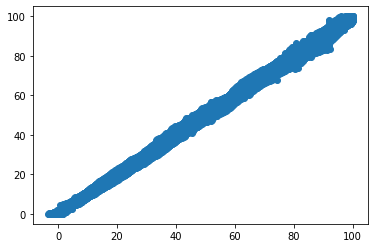

In [43]:
correct = 0

plt.figure()
plt.scatter(pred, actual)
for iter in range(len(actual)):
  if actual[iter]<2 or actual[iter]>98:
    correct+=1
    continue
  if (abs(actual[iter] - pred[iter]) <= 4):
    correct+=1


print(correct)
print(len(actual))

print("Precision: ", correct * 100/len(actual))

Text(0.5, 1.0, 'Actual vs Prediction')

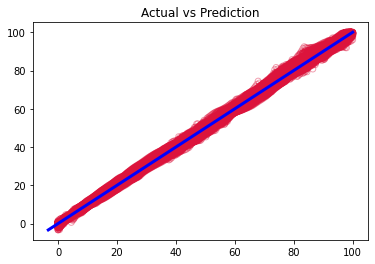

In [44]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

In [45]:
#model_save_path="/content/drive/MyDrive/nmchr_lab/models/model_encoder_decoder_MS"

#encoder_decoder.save(model_save_path)

In [46]:
mlp_model = Sequential()
mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=train_encoded.shape[1]))
mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(2))
mlp_model.summary()

adam = optimizers.Adam(lr)
mlp_model.compile(loss='mse', optimizer=adam)
lrate = LearningRateScheduler(step_decay)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                352       
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                                 
 dense_6 (Dense)             (None, 2)                 18        
                                                                 
Total params: 634
Trainable params: 634
Non-trainable params: 0
_________________________________________________________________
